In [1]:
%matplotlib inline
import numpy as np

In [2]:
import tensorflow_datasets as tfds
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

W0813 21:13:28.011834  6968 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


In [3]:
train_data, test_data = imdb['train'], imdb['test']

train_sentences, train_labels = zip(*[(data[0].numpy().decode('utf-8'), data[1].numpy()) for data in train_data])
train_labels = np.array(train_labels)

test_sentences, test_labels = zip(*[(data[0].numpy().decode('utf-8'), data[1].numpy()) for data in test_data])
test_labels = np.array(test_labels)

In [4]:
VOCAB_SIZE = 10000
EMBEDDING_DIM = 16
MAX_LEN = 120
OOV_TOKEN = '<OOV>'
TRUNCATING = 'post'

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index
index_word = tokenizer.index_word

In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_sequences = pad_sequences(train_sequences, maxlen=MAX_LEN, truncating=TRUNCATING)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_sequences = pad_sequences(test_sequences, maxlen=MAX_LEN, truncating=TRUNCATING)

In [7]:
def decode(sequence):
    return ' '.join([index_word.get(c, "?") for c in sequence])

seq = tokenizer.texts_to_sequences(["The quick brown fox jumps over the lazy dog"])
print(decode(seq[0]))

the quick brown fox jumps over the lazy dog


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN),
    Flatten(),
    Dense(6, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 11526     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(train_sequences, train_labels, epochs=10, validation_data=(test_sequences, test_labels), verbose=0)

W0813 21:13:48.573038  6968 deprecation.py:323] From d:\Dev\Miniconda3\envs\tf\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


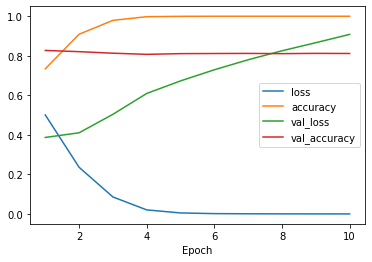

In [10]:
from util import plot_history

plot_history(history)

In [11]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print("VOCAB_SIZE x EMBEDDING_DIM: {} x {}".format(VOCAB_SIZE, EMBEDDING_DIM))
print("weights.shape = {}".format(weights.shape))

VOCAB_SIZE x EMBEDDING_DIM: 10000 x 16
weights.shape = (10000, 16)


In [12]:
import csv

with open('vectors.tsv', 'w', newline='\n', encoding='utf-8') as f:
    writer = csv.writer(f, delimiter='\t')
    for idx in range(1, VOCAB_SIZE):
        embeddings = weights[idx]
        writer.writerow(embeddings)
        
with open('metadata.tsv', 'w', encoding='utf-8') as f:
    f.writelines([index_word[idx] + '\n' for idx in range(1, VOCAB_SIZE)])

https://projector.tensorflow.org/